In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2



import os

import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img
from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense,Conv2D, MaxPooling2D,GlobalMaxPooling2D
from keras.optimizers import Adam
from keras.models import Model
from keras import optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

C:\Users\cig79850\AppData\Local\Temp\ipykernel_18672\2717308369.py:11: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
img_width=150
img_height=150
batch_size=20
input_shape = (img_width, img_height, 3)

In [3]:
# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.3,
    zoom_range=[0.6,1.0],
    brightness_range=[0.6,1.0],
    rotation_range=90,
    horizontal_flip=True,
    validation_split=0.2
)

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory(
    r'C:\Users\cig79850\Downloads\Kaggle_CatsVSDogs\kagglecatsanddogs_3367a\PetImages',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical',
    seed = 42,
    subset='training'
    
)
valid_generator = train_datagen.flow_from_directory(
    r'C:\Users\cig79850\Downloads\Kaggle_CatsVSDogs\kagglecatsanddogs_3367a\PetImages',
    target_size=(img_width, img_height),
    batch_size=batch_size,
    #class_mode='binary',
    class_mode='categorical',
    seed = 42,
    subset='validation'
    
)
#X, y = next(train_generator)

Found 19968 images belonging to 2 classes.
Found 4991 images belonging to 2 classes.


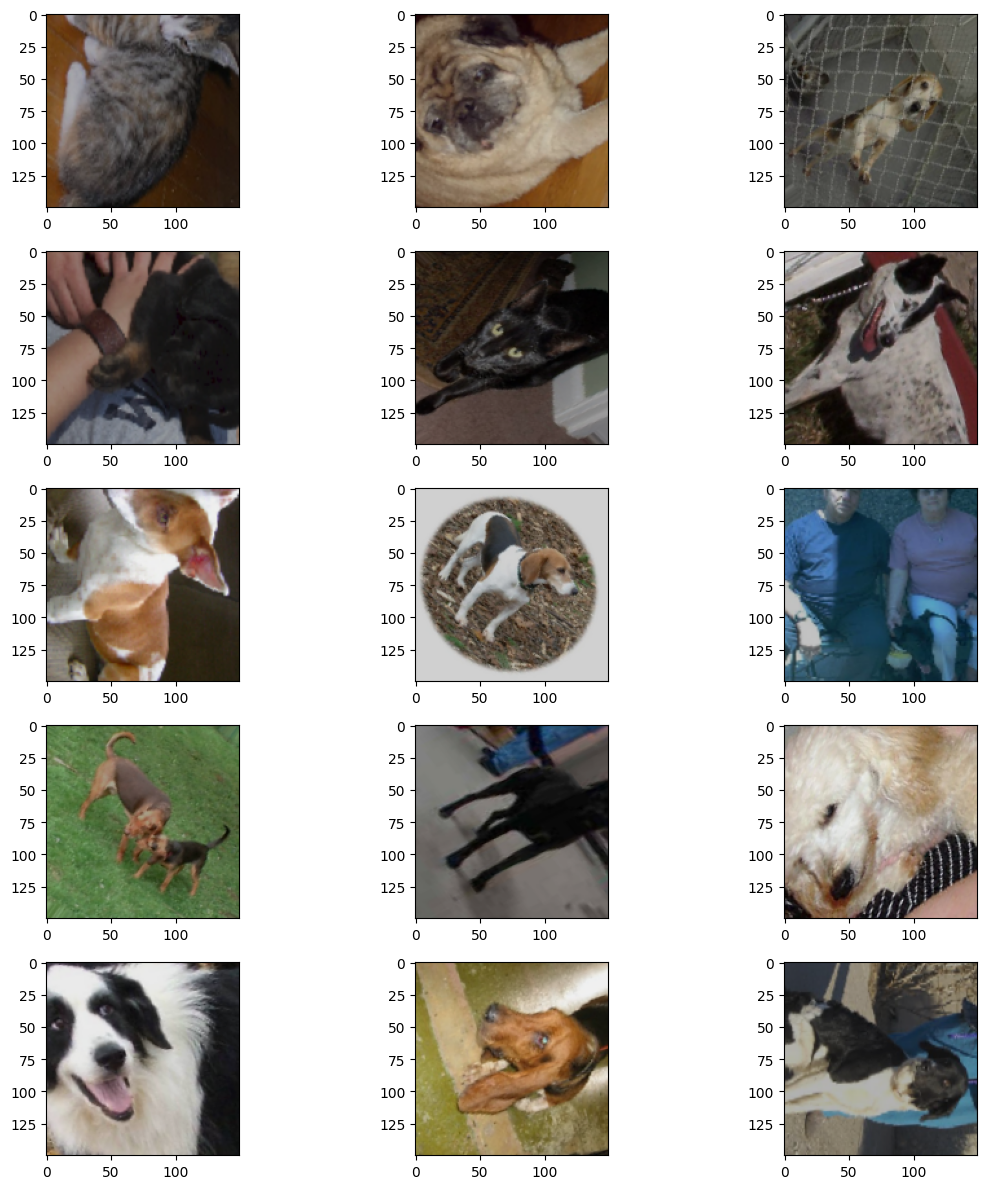

In [4]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in train_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [5]:
####################### VGG16
from keras.applications import VGG16
pre_trained_model = VGG16(input_shape=(150, 150, 3), include_top=False, weights="imagenet")

for layer in pre_trained_model.layers[:15]:
    layer.trainable = False

for layer in pre_trained_model.layers[15:]:
    layer.trainable = True
    
last_layer = pre_trained_model.get_layer('block5_pool')
last_output = last_layer.output

In [6]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [7]:
# Flatten the output layer to 1 dimension
x = GlobalMaxPooling2D()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = Dense(512, activation='relu')(x)
# Add a dropout rate of 0.5
x = Dropout(0.5)(x)
# Add a final sigmoid layer for classification
#x = Dense(1, activation='sigmoid')(x)
x = Dense(2, activation='softmax')(x)
model = Model(pre_trained_model.input, x)

In [8]:
model.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(learning_rate=1e-4, momentum=0.9),
              metrics=['acc'])

In [9]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
#earlystop = EarlyStopping(patience=5)
earlystop=EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=20, verbose=0, mode='auto')
callbacks = [earlystop]

In [10]:
history = model.fit_generator(
            train_generator,
            validation_data = valid_generator,
            steps_per_epoch = 100,
            epochs = 150,
            validation_steps = 50,
            verbose = 1
            ,callbacks=callbacks
)

Epoch 1/150


C:\Users\cig79850\AppData\Local\Temp\ipykernel_18672\2822385610.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(




100/100 [==============================] - 90s 897ms/step - loss: 0.7596 - acc: 0.5145 - val_loss: 0.6785 - val_acc: 0.5730
Epoch 2/150
 75/100 [=====================>........] - ETA: 16s - loss: 0.7180 - acc: 0.5593

C:\ProgramData\anaconda3\envs\dlenv\Lib\site-packages\PIL\TiffImagePlugin.py:870: UserWarning: Truncated File Read
  warnings.warn(str(msg))


100/100 [==============================] - 92s 922ms/step - loss: 0.7087 - acc: 0.5720 - val_loss: 0.6476 - val_acc: 0.6720
Epoch 3/150
100/100 [==============================] - 90s 906ms/step - loss: 0.6830 - acc: 0.5995 - val_loss: 0.6254 - val_acc: 0.6910
Epoch 4/150
100/100 [==============================] - 93s 932ms/step - loss: 0.6426 - acc: 0.6595 - val_loss: 0.6003 - val_acc: 0.7100
Epoch 5/150
100/100 [==============================] - 92s 925ms/step - loss: 0.6240 - acc: 0.6740 - val_loss: 0.5757 - val_acc: 0.7280
Epoch 6/150
100/100 [==============================] - 91s 907ms/step - loss: 0.5815 - acc: 0.7090 - val_loss: 0.5415 - val_acc: 0.7510
Epoch 7/150
100/100 [==============================] - 90s 905ms/step - loss: 0.5594 - acc: 0.7365 - val_loss: 0.5176 - val_acc: 0.7660
Epoch 8/150
100/100 [==============================] - 91s 912ms/step - loss: 0.5223 - acc: 0.7570 - val_loss: 0.4857 - val_acc: 0.7920
Epoch 9/150
100/100 [==============================] - 90s 9

Text(0.5, 1.0, 'Training and validation loss')

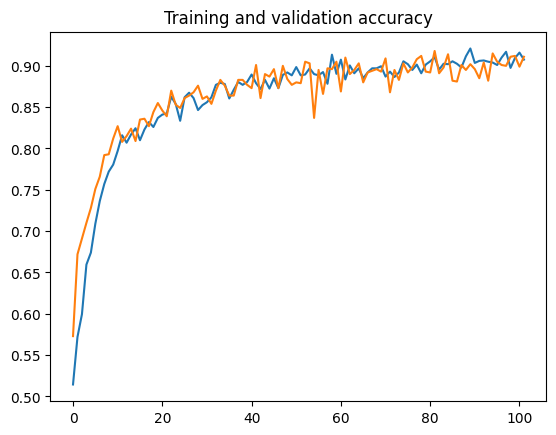

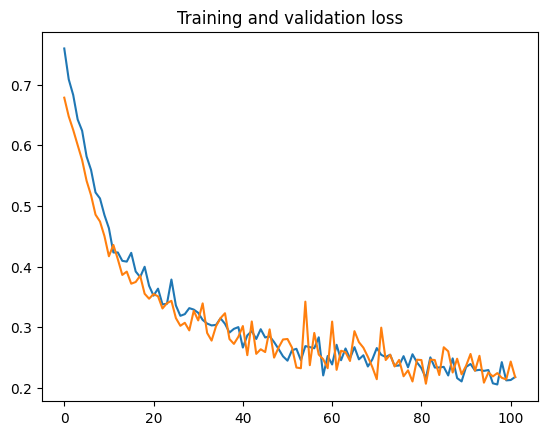

In [11]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt
acc      = history.history[     'acc' ]
val_acc  = history.history[ 'val_acc' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [12]:
# save model
from keras.models import load_model
model.save('VGG16_dog_cat_cnn_model_100_epochs.keras')

In [16]:
# model.evaluate(test_features, test_labels)
# pd.DataFrame(history.history).plot()

NameError: name 'test_features' is not defined

In [ ]:
import keras
new_model = keras.models.load_model('VGG16_dog_cat_cnn_model.keras')

In [ ]:
val_loss, val_acc = model.evaluate(valid_generator)  # evaluate the out of sample data with model
#print(val_loss)  # model's loss (error)

In [ ]:
print(val_acc)  # model's accuracy